In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from openTSNE import TSNE
import umap

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
import hdbscan
from sklearn import mixture

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score

from time import time
import seaborn as sns

# Configuration

umap_seed = 143
tsne_seed = 42
max_jobs = -1    # If the RAM gets used up in your case, modify it to reduce RAM usage
num_comp = 2
num_clusters = 2

/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset extraction and analysis

In [2]:
path_expression = '../data/TCGA.BRCA.expression.txt'
path_metadata = '../data/TCGA.BRCA.metadata.txt'
path_mutation = '../data/TCGA.BRCA.mutations.txt'

df_exp = pd.read_csv(path_expression, delimiter='\t')  # \s+ handles multiple spaces
df_meta = pd.read_csv(path_metadata, delimiter='\t')
df_mut = pd.read_csv(path_mutation, delimiter='\t')

KeyboardInterrupt: 

In [ ]:
df_exp.head()

,patient_id,sample_id,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,...,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
0,TCGA-3C-AAAU,TCGA-3C-AAAU-01A-11R-A41B-07,0.0000,16.3644,12.9316,52.1503,408.076,0.0,1187.010,0.0000,...,415.824,931.957,129.5920,1007.780,1658.500,258.4940,1208.370,3507.25,1894.930,1180.460
1,TCGA-3C-AALI,TCGA-3C-AALI-01A-11R-A41B-07,0.0000,9.2659,17.3790,69.7553,563.893,0.0,516.041,1.0875,...,1161.330,965.198,59.8151,448.613,1343.120,198.4770,603.589,5504.62,1318.650,406.743
2,TCGA-3C-AALJ,TCGA-3C-AALJ-01A-31R-A41B-07,0.9066,11.6228,9.2294,154.2970,1360.830,0.0,592.022,0.0000,...,305.422,2531.280,35.3581,533.998,768.812,331.8220,532.185,5458.75,942.883,509.519
3,TCGA-3C-AALK,TCGA-3C-AALK-01A-11R-A41B-07,0.0000,12.0894,11.0799,143.8640,865.536,0.0,552.751,0.4137,...,394.506,668.597,55.0269,437.733,863.881,175.4240,607.365,5691.35,781.134,700.869
4,TCGA-4H-AAAK,TCGA-4H-AAAK-01A-12R-A41B-07,0.0000,6.8468,14.4298,84.2128,766.383,0.0,260.851,0.4255,...,405.711,674.468,48.9362,424.255,1049.790,14.0426,775.745,4041.70,831.915,881.702


In [ ]:
df_meta.head()

,patient_id,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,histological_type,histological_grade,tumor_status,vital_status,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,TCGA-3C-AAAU,BRCA,55.0,FEMALE,WHITE,Stage X,Infiltrating Lobular Carcinoma,[Not Available],WITH TUMOR,Alive,0.0,4047.0,0.0,4047.0,1.0,1808.0,1.0,1808.0,NaN
1,TCGA-3C-AALI,BRCA,50.0,FEMALE,BLACK OR AFRICAN AMERICAN,Stage IIB,Infiltrating Ductal Carcinoma,[Not Available],TUMOR FREE,Alive,0.0,4005.0,0.0,4005.0,0.0,4005.0,0.0,4005.0,NaN
2,TCGA-3C-AALJ,BRCA,62.0,FEMALE,BLACK OR AFRICAN AMERICAN,Stage IIB,Infiltrating Ductal Carcinoma,[Not Available],TUMOR FREE,Alive,0.0,1474.0,0.0,1474.0,0.0,1474.0,0.0,1474.0,NaN
3,TCGA-3C-AALK,BRCA,52.0,FEMALE,BLACK OR AFRICAN AMERICAN,Stage IA,Infiltrating Ductal Carcinoma,[Not Available],TUMOR FREE,Alive,0.0,1448.0,0.0,1448.0,NaN,NaN,0.0,1448.0,NaN
4,TCGA-4H-AAAK,BRCA,50.0,FEMALE,WHITE,Stage IIIA,Infiltrating Lobular Carcinoma,[Not Available],TUMOR FREE,Alive,0.0,348.0,0.0,348.0,0.0,348.0,0.0,348.0,NaN


In [ ]:
df_mut.head()

,patient_id,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,...,SIFT,PolyPhen,DOMAINS,IMPACT,VARIANT_CLASS,FILTER,COSMIC,CALLERS,CONTEXT,NCALLERS
0,TCGA-3C-AAAU,WDR11,0,.,GRCh37,10,122668955,122668955,+,3'UTR,...,.,.,.,MODIFIER,SNV,PASS,NONE,SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS,TATGAGATGTA,5
1,TCGA-3C-AAAU,GATA3,0,.,GRCh37,10,8115874,8115875,+,Frame_Shift_Ins,...,.,.,"Low_complexity_(Seg):seg,hmmpanther:PTHR10071:...",HIGH,insertion,PASS,NONE,INDELOCATOR*|VARSCANI*|PINDEL,CATCTCGCCCT,3
2,TCGA-3C-AAAU,MALAT1,0,.,GRCh37,11,65272906,65272908,+,RNA,...,.,.,.,MODIFIER,deletion,PASS,NONE,VARSCANI*|PINDEL,AATAATAAAGCCCA,2
3,TCGA-3C-AAAU,CD248,0,.,GRCh37,11,66082467,66082467,+,Missense_Mutation,...,tolerated(0.12),benign(0.001),"Low_complexity_(Seg):seg,hmmpanther:PTHR24838:...",MODERATE,SNV,PASS,NONE,MUTECT|VARSCANS,GTGCTCGGCAA,2
4,TCGA-3C-AAAU,NPAS4,0,.,GRCh37,11,66193652,66193652,+,3'UTR,...,.,.,.,MODIFIER,SNV,PASS,NONE,RADIA|MUTECT|MUSE|VARSCANS,ATCAAGAGACT,4


# Data preprocessing

### Bulk RNA-seq of PBMC from 65 donors with systemic lupus erythematosus (SLE) and 20 healthy donors

This is from the paper and it needs the .csv file mentioned in the readme file. We need to repurpose it for our case.
GSE121239_series_matrix.txt.gz from https://ftp.ncbi.nlm.nih.gov/geo/series/GSE121nnn/GSE121239/matrix/. Unzip it.

It's an example to illustrate UMAP can be used to discover new features

(not batch effects, not experimental groups, annotated sample featuers like gender, geographical location, time of visit...)

each of the 65 SLE donors have 3 or more visits (3+ samples per SLE donor)

A 54,715 probes by 311 samples matrix

In [ ]:
link_paper = 'https://ftp.ncbi.nlm.nih.gov/geo/series/GSE121nnn/GSE121239/matrix/GSE121239_series_matrix.txt.gz'
!wget $link_paper
!gunzip GSE121239_series_matrix.txt.gz
data = pd.read_csv('GSE121239_series_matrix.txt', sep='\t', comment='!', header=0)

--2025-04-05 21:43:06--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE121nnn/GSE121239/matrix/GSE121239_series_matrix.txt.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.10, 130.14.250.11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92993584 (89M) [application/x-gzip]
Saving to: ‘GSE121239_series_matrix.txt.gz’

GSE121239_series_ma 100%[===================>]  88.69M  11.5MB/s    in 9.1s    

2025-04-05 21:43:16 (9.78 MB/s) - ‘GSE121239_series_matrix.txt.gz’ saved [92993584/92993584]



In [ ]:
data.head()

,ID_REF,GSM3428310,GSM3428311,GSM3428312,GSM3428313,GSM3428314,GSM3428315,GSM3428316,GSM3428317,GSM3428318,...,GSM3428612,GSM3428613,GSM3428614,GSM3428615,GSM3428616,GSM3428617,GSM3428618,GSM3428619,GSM3428620,GSM3428621
0,1007_PM_s_at,4.955257,4.870351,4.889382,4.956931,4.518659,4.039076,4.363994,4.474612,4.109501,...,4.143518,4.163726,3.552997,4.688624,4.101748,3.987773,4.674258,4.855265,5.227129,5.702039
1,1053_PM_at,5.984784,6.119432,5.914195,5.887814,5.962590,6.213503,6.523682,6.630676,6.424815,...,5.601486,5.307239,5.585876,6.538760,6.420332,5.949633,5.587069,6.032248,6.317659,6.449117
2,117_PM_at,9.477945,9.828793,9.719707,9.148228,9.378308,9.688581,8.985668,10.329326,8.890190,...,9.077410,9.349135,9.554533,9.941707,10.278584,9.672171,8.650779,9.264324,9.430051,9.660996
3,121_PM_at,4.553229,4.487615,4.645168,4.681996,4.990632,4.762670,4.528352,4.693206,3.875943,...,5.177162,4.961182,5.267552,4.404966,4.013917,4.234865,4.418242,4.269110,4.115500,4.135403
4,1255_PM_g_at,1.921190,2.169639,2.410481,1.885852,1.987256,2.029976,2.110129,2.136902,2.169476,...,2.224418,2.158327,2.316911,1.942149,1.929420,1.862300,1.842566,2.258901,1.951895,1.896087


Column names contain the Affymetrix microarray probe name and 312 samples for bulk RNA-seq

In [ ]:
data.columns

Index(['ID_REF', 'GSM3428310', 'GSM3428311', 'GSM3428312', 'GSM3428313',
       'GSM3428314', 'GSM3428315', 'GSM3428316', 'GSM3428317', 'GSM3428318',
       ...
       'GSM3428612', 'GSM3428613', 'GSM3428614', 'GSM3428615', 'GSM3428616',
       'GSM3428617', 'GSM3428618', 'GSM3428619', 'GSM3428620', 'GSM3428621'],
      dtype='object', length=313)

Pick a random row (probe) from the 54,715 rows (probes) to get the 312 samples' expression of the gene detected by that probe

In [ ]:
# Have to check how the paper handle the data and how we are using the data
# The paper just picked this random row, belonging to control probe AFFX-r2-TagJ-3_at (antisense target (at) that binds uniquely to a target)
label_group = data[(data.shape[0] - 12): (data.shape[0] - 11)]
label_group

,ID_REF,GSM3428310,GSM3428311,GSM3428312,GSM3428313,GSM3428314,GSM3428315,GSM3428316,GSM3428317,GSM3428318,...,GSM3428612,GSM3428613,GSM3428614,GSM3428615,GSM3428616,GSM3428617,GSM3428618,GSM3428619,GSM3428620,GSM3428621
54703,AFFX-r2-TagJ-3_at,3.979583,3.764423,3.79976,3.803006,3.921403,3.387239,3.314623,3.51697,3.581877,...,4.159133,4.057117,4.592492,4.542591,3.333782,3.418539,3.230674,3.714433,3.405621,3.74714


In [ ]:
# remove label info (ID_REF column) and flatten and simplify the matrix into an array of integers
label_group.drop(label_group.columns[[0,1]], axis = 1, inplace = True)
label_group = label_group.to_numpy()
label_group = label_group[0,:]
label_group = label_group.astype(int)
print(label_group)
print(len(label_group), "samples")

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 4 4 3 3 4 4 3 3 3 4 4 3 3 4 3 3 3
 3 3 3 3 4 4 3 3 3 3 4 3 3 3 3 3 3 3 4 4 3 3 4 3 3 3 3 3 3 3 4 3 3 3 4 4 3
 4 4 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 4
 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 3 3 3 4 3 3 3 3 3 4 3
 3 3 3 3 4 3 3 4 4 3 3 3 3 3 3 3 4 3 3 3 4 3 3 3 4 4 3 4 4 3 3 3 4 4 3 3 3
 3 3 3 3 4 3 3 3 3 3 4 3 3 3 3 4 3 3 4 4 3 3 4 4 3 3 3 3 3 3 4 3 3 3 3 4 3
 3 2 4 3 3 4 3 3 4 3 3 4 3 3 3 2 3 3 3 3 3 3 3 3 3 3 4 3 3 4 3 3 3 3 3 3 3
 4 4 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 2 3 2 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 4
 3 4 4 3 4 4 4 4 4 3 3 3 3 3 3]
311 samples


<ipython-input-11-9b5216676752>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label_group.drop(label_group.columns[[0,1]], axis = 1, inplace = True)


In [ ]:
data[0:1]

,ID_REF,GSM3428310,GSM3428311,GSM3428312,GSM3428313,GSM3428314,GSM3428315,GSM3428316,GSM3428317,GSM3428318,...,GSM3428612,GSM3428613,GSM3428614,GSM3428615,GSM3428616,GSM3428617,GSM3428618,GSM3428619,GSM3428620,GSM3428621
0,1007_PM_s_at,4.955257,4.870351,4.889382,4.956931,4.518659,4.039076,4.363994,4.474612,4.109501,...,4.143518,4.163726,3.552997,4.688624,4.101748,3.987773,4.674258,4.855265,5.227129,5.702039


In [ ]:
data[1:(data.shape[0]-12)]

,ID_REF,GSM3428310,GSM3428311,GSM3428312,GSM3428313,GSM3428314,GSM3428315,GSM3428316,GSM3428317,GSM3428318,...,GSM3428612,GSM3428613,GSM3428614,GSM3428615,GSM3428616,GSM3428617,GSM3428618,GSM3428619,GSM3428620,GSM3428621
1,1053_PM_at,5.984784,6.119432,5.914195,5.887814,5.962590,6.213503,6.523682,6.630676,6.424815,...,5.601486,5.307239,5.585876,6.538760,6.420332,5.949633,5.587069,6.032248,6.317659,6.449117
2,117_PM_at,9.477945,9.828793,9.719707,9.148228,9.378308,9.688581,8.985668,10.329326,8.890190,...,9.077410,9.349135,9.554533,9.941707,10.278584,9.672171,8.650779,9.264324,9.430051,9.660996
3,121_PM_at,4.553229,4.487615,4.645168,4.681996,4.990632,4.762670,4.528352,4.693206,3.875943,...,5.177162,4.961182,5.267552,4.404966,4.013917,4.234865,4.418242,4.269110,4.115500,4.135403
4,1255_PM_g_at,1.921190,2.169639,2.410481,1.885852,1.987256,2.029976,2.110129,2.136902,2.169476,...,2.224418,2.158327,2.316911,1.942149,1.929420,1.862300,1.842566,2.258901,1.951895,1.896087
5,1294_PM_at,8.164253,7.886918,7.890372,8.006514,8.223370,7.615219,7.518055,7.593616,7.756518,...,8.403333,7.722717,7.902521,7.554671,8.580205,7.906560,7.470552,7.490315,8.448537,8.114021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54698,AFFX-r2-TagG_at,2.689607,2.031049,2.913522,2.324065,2.669534,2.624752,2.224233,2.208881,2.437850,...,2.155512,2.803698,3.497325,2.974102,2.678248,2.496272,3.158489,2.356490,2.048256,2.077832
54699,AFFX-r2-TagH_at,2.406163,2.294529,2.778777,2.363397,2.373651,2.265417,2.426325,2.423764,2.518814,...,2.711161,2.287911,2.711640,2.193308,2.295329,2.292885,2.540755,2.248449,1.877248,2.069802
54700,AFFX-r2-TagIN-3_at,3.242750,3.168408,3.297348,3.031308,2.854557,3.129650,2.773570,3.215764,3.215198,...,3.161837,3.403710,3.424648,3.090719,3.356710,3.520598,3.232806,2.781072,2.951410,2.982322
54701,AFFX-r2-TagIN-5_at,2.185184,2.253620,2.399328,1.961517,2.283897,2.666337,2.556509,2.187858,2.371318,...,2.316161,2.392318,2.959787,2.257656,2.264382,2.078712,1.713641,2.264092,1.945215,2.316979


In [ ]:
data_no_label = data.copy()
data_no_label = data_no_label[0:(data_no_label.shape[0]-12)] # All probes up till probe AFFX-r2-TagJ-3_at, so 54,715 - 12 = 54,702 rows
### Note!
# Original code
# data[1:(data.shape[0]-12)]
# So somehow they didn't include the 311 values from the first probe 1007_PM_s_at

data_no_label.drop(data_no_label.columns[[0,1]], axis = 1, inplace = True) # remove label info (ID_REF column)
data_no_label = data_no_label.to_numpy() # turn into a 54,702 probes by 311 samples matrix

# Tranpose to be a 311 by 54,702 matrix
data_no_label = np.transpose(data_no_label)
print(data_no_label.shape)
print(data_no_label)

### log_2 transformation ###
## Note that the original code commented this out
############################
# data_no_label= np.log2(data_no_label)


(311, 54703)
[[4.8703508  6.11943192 9.82879307 ... 3.16840765 2.25362011 3.1347314 ]
 [4.88938214 5.91419478 9.71970737 ... 3.29734796 2.39932788 2.75425312]
 [4.956931   5.88781354 9.148228   ... 3.03130809 1.96151656 2.53706892]
 ...
 [4.85526539 6.03224763 9.26432392 ... 2.78107154 2.26409228 2.92635925]
 [5.22712872 6.31765866 9.4300507  ... 2.95141019 1.94521515 2.95269502]
 [5.70203929 6.44911709 9.66099638 ... 2.982322   2.31697917 2.93035054]]


# Dimensional reduction
Figure 5b

t-SNE package has a parameter to specify [Barnes-Hut] approximation method(https://jheer.github.io/barnes-hut/), which

Construct the spatial index (e.g., quadtree), calculate centers of mass, then estimate forces (interaction between two points)

In [ ]:
print(label_group)
print(data_no_label)

[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 4 4 3 3 4 4 3 3 3 4 4 3 3 4 3 3 3
 3 3 3 3 4 4 3 3 3 3 4 3 3 3 3 3 3 3 4 4 3 3 4 3 3 3 3 3 3 3 4 3 3 3 4 4 3
 4 4 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 4 4 3 3 3 3 3 4
 3 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 3 3 3 4 3 3 3 3 3 4 3
 3 3 3 3 4 3 3 4 4 3 3 3 3 3 3 3 4 3 3 3 4 3 3 3 4 4 3 4 4 3 3 3 4 4 3 3 3
 3 3 3 3 4 3 3 3 3 3 4 3 3 3 3 4 3 3 4 4 3 3 4 4 3 3 3 3 3 3 4 3 3 3 3 4 3
 3 2 4 3 3 4 3 3 4 3 3 4 3 3 3 2 3 3 3 3 3 3 3 3 3 3 4 3 3 4 3 3 3 3 3 3 3
 4 4 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 2 3 2 3 3 3 3 4 3 3 3 3 3 3 3 3 3 3 3 4
 3 4 4 3 4 4 4 4 4 3 3 3 3 3 3]
[[4.8703508  6.11943192 9.82879307 ... 3.16840765 2.25362011 3.1347314 ]
 [4.88938214 5.91419478 9.71970737 ... 3.29734796 2.39932788 2.75425312]
 [4.956931   5.88781354 9.148228   ... 3.03130809 1.96151656 2.53706892]
 ...
 [4.85526539 6.03224763 9.26432392 ... 2.78107154 2.26409228 2.92635925]
 [5.22712872 6.31765866 9.4300507  ... 2.95141019 1.94521515 2.95269502

In [ ]:
def pca_reduce(data_no_label,n_comp = num_comp):
  t0 = time()
  scaler = StandardScaler()
  data_scale = scaler.fit_transform(data_no_label)
  pca = PCA(n_components = n_comp)
  embedding_pca = pca.fit_transform(data_scale)
  t1 = time()
  print('PCA running time is: ' + str(t1-t0) + ' s' )

  return embedding_pca


def mds_reduce(data_no_label,n_comp = num_comp,m_job = max_jobs):
  t0 = time()
  embedding_mds = MDS(n_components=n_comp, n_jobs=m_job).fit_transform(data_no_label)
  t1 = time()
  print('MDS running time is: ' + str(t1-t0) + ' s' )

  return embedding_mds


def tsne_reduce(data_no_label,n_comp = num_comp, r_seed = tsne_seed, m_job = max_jobs, grad = 'bh'):
  t0 = time()
  embedding_tsne = TSNE(n_components=n_comp, random_state= r_seed, n_jobs=m_job, negative_gradient_method=grad).fit(data_no_label)
  t1 = time()
  print('t-SNE running time is: ' + str(t1-t0) + ' s' )

  return embedding_tsne


def umap_reduce(data_no_label,n_comp = num_comp, measure='euclidean', r_seed = umap_seed, m_job = max_jobs):
  t0 = time()
  reducer = umap.UMAP(n_components = n_comp, metric=measure, random_state=r_seed, n_jobs=m_job) # negative_gradient_method=grad is no longer a parameter in Python umap
  embedding_umap = reducer.fit_transform(data_no_label)
  t1 = time()
  print('UMAP running time is: ' + str(t1-t0) + ' s' )

  return embedding_umap


def plot_embedding(embedding, label = label_group, title='UMAP'):
    fig, ax = plt.subplots()
    scatter = ax.scatter(embedding[:, 0],embedding[:, 1], c=[sns.color_palette(n_colors = 20)[x] for x in label])
    ax.set_title(title)
    plt.axis('off')
    plt.show()

In [ ]:
embedding_pca = pca_reduce(data_no_label)
embedding_mds = mds_reduce(data_no_label)
embedding_tsne = tsne_reduce(data_no_label)
embedding_umap = umap_reduce(data_no_label)

PCA running time is: 0.6733748912811279 s
MDS running time is: 5.022506952285767 s
t-SNE running time is: 20.41135835647583 s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 6.452546119689941 s


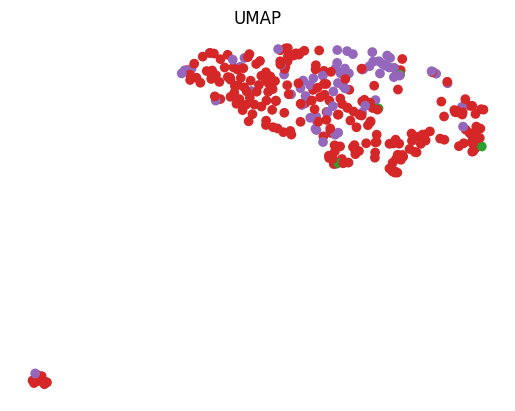

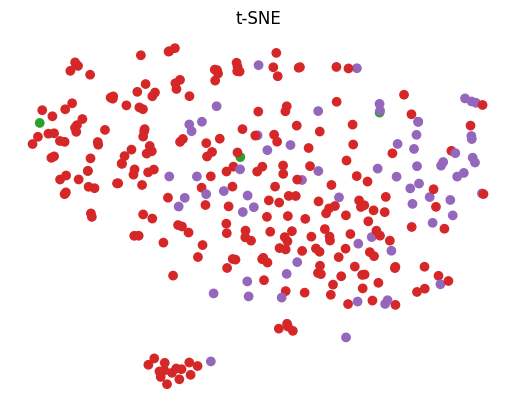

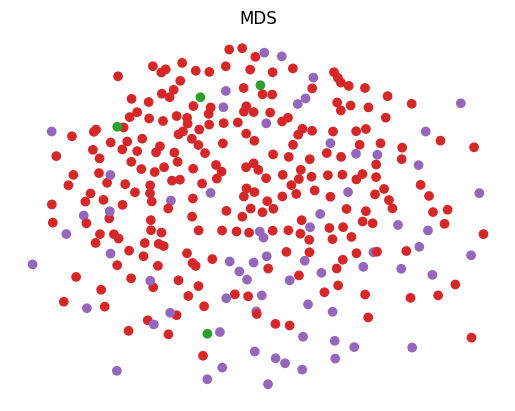

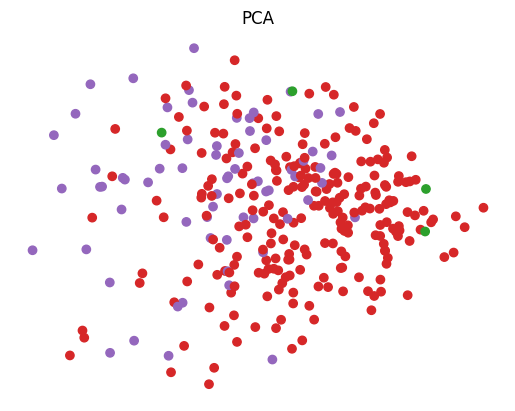

In [ ]:
plot_embedding(embedding_umap, title='UMAP')
plot_embedding(embedding_tsne, title='t-SNE')
plot_embedding(embedding_mds, title='MDS')
plot_embedding(embedding_pca, title='PCA')

# Clustering algorithmn

In [ ]:
# K-means
km = KMeans(n_clusters = num_clusters, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
kmeans_umap = km.fit_predict(embedding_umap)
kmeans_tsne = km.fit_predict(embedding_tsne)
kmeans_mds = km.fit_predict(embedding_mds)
kmeans_pca = km.fit_predict(embedding_pca)

# Hierarchical clustering:  AgglomerativeClustering
clusterer_hierarchical = AgglomerativeClustering(n_clusters = num_clusters )
hc_umap = clusterer_hierarchical.fit_predict(embedding_umap)
hc_tsne = clusterer_hierarchical.fit_predict(embedding_tsne)
hc_mds = clusterer_hierarchical.fit_predict(embedding_mds)
hc_pca = clusterer_hierarchical.fit_predict(embedding_pca)

# SpectralClustering
spectral_Clustering = SpectralClustering(n_clusters = num_clusters, assign_labels="discretize", random_state=0)
spc_umap = spectral_Clustering.fit_predict(embedding_umap)
spc_tsne = spectral_Clustering.fit_predict(embedding_tsne)
spc_mds = spectral_Clustering.fit_predict(embedding_mds)
spc_pca = spectral_Clustering.fit_predict(embedding_pca)

# Gaussian mixture model
gmm = mixture.GaussianMixture(n_components = num_clusters, covariance_type='full')
gmm_umap = gmm.fit_predict(embedding_umap)
gmm_tsne = gmm.fit_predict(embedding_tsne)
gmm_mds = gmm.fit_predict(embedding_mds)
gmm_pca = gmm.fit_predict(embedding_pca)


# HDBSCAN
clusterer_hdbscan = hdbscan.HDBSCAN(min_cluster_size = 10, gen_min_span_tree=True)
hdbscan_umap = clusterer_hdbscan.fit_predict(embedding_umap)
hdbscan_tsne = clusterer_hdbscan.fit_predict(embedding_tsne)
hdbscan_mds = clusterer_hdbscan.fit_predict(embedding_mds)
hdbscan_pca = clusterer_hdbscan.fit_predict(embedding_pca)

#clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', edge_alpha=0.6, node_size=80, edge_linewidth=2)
#clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
#clusterer.condensed_tree_.plot()

cluster_result = [kmeans_umap,kmeans_tsne,kmeans_mds,kmeans_pca,
                  hc_umap,hc_tsne,hc_mds,hc_pca,
                  spc_umap,spc_tsne,spc_mds,spc_pca,
                  gmm_umap,gmm_tsne,gmm_mds,gmm_pca,
                  hdbscan_umap,hdbscan_tsne,hdbscan_mds,hdbscan_pca]


file = open("clustering_accuracy_NMI.txt","a") #append mode
file.write( 'clustering_accuracy_NMI.txt' + "\n")
for _, cluster in enumerate(cluster_result):
   nmi = normalized_mutual_info_score(label_group, cluster)
   file.write(str(nmi) + "\n")
file.close()

file = open("clustering_accuracy_ARI.txt","a") #append mode
file.write( 'clustering_accuracy_ARI.txt' + "\n")
for _, cluster in enumerate(cluster_result):
   ari = adjusted_rand_score(label_group, cluster)
   file.write(str(ari) + "\n")
file.close()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-pack

# lkn
Figure 5d

In [ ]:
label_days_cummulated = data.copy()
label_days_cummulated = label_days_cummulated[(label_days_cummulated.shape[0] - 1): (label_days_cummulated.shape[0])]

label_days_cummulated.drop(label_days_cummulated.columns[[0,1]], axis = 1, inplace = True)
label_days_cummulated = label_days_cummulated.to_numpy()
label_days_cummulated = label_days_cummulated[0,:]
label_days_cummulated = label_days_cummulated.astype(int)

(np.float64(1.7080167531967163),
 np.float64(7.465513229370117),
 np.float64(8.747621536254883),
 np.float64(14.536395072937012))

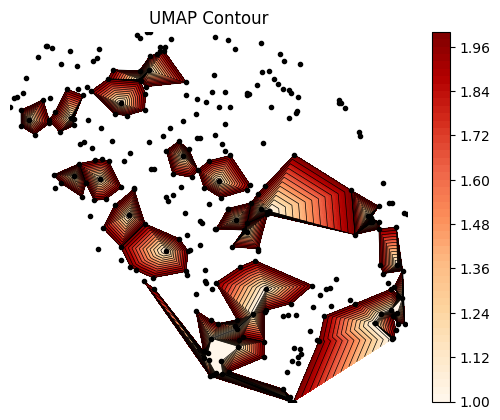

In [ ]:
#######################################################################
# Contour plot showing the visiting timestamp of each sample point
#######################################################################


fig, ax = plt.subplots()
ax.tricontour(embedding_umap[20:,0], embedding_umap[20:,1], label_days_cummulated[20:], levels=15, linewidths=0.5, colors='k')
tcf =  ax.tricontourf(embedding_umap[20:,0], embedding_umap[20:,1], label_days_cummulated[20:], levels=50, cmap="OrRd")
fig.colorbar(tcf, ax=ax)
ax.plot(embedding_umap[20:,0], embedding_umap[20:,1], 'ko', ms=3)
ax.set_title("UMAP Contour")
plt.axis('off')

# Metric
Figure 5e

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 1.4693403244018555 s


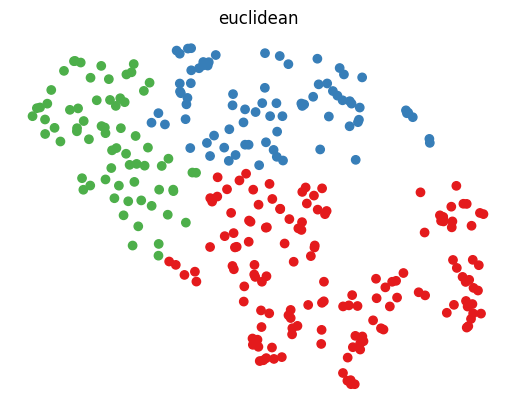

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 6.58835506439209 s


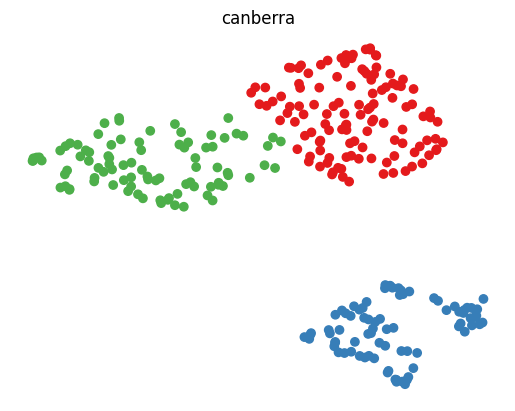

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 4.170558452606201 s


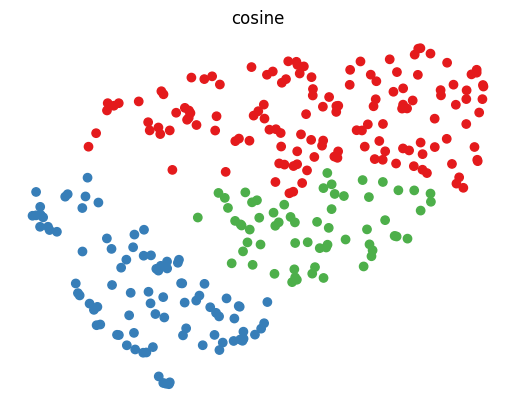

In [ ]:
def plot_cluster(embedding, title='Eucledian'):
  fig, ax = plt.subplots()
  clusterer_hierarchical = AgglomerativeClustering(n_clusters = 3)
  clustering = clusterer_hierarchical.fit(embedding[20:,])
  ax.scatter(embedding[20:, 0], embedding[20:, 1],
            c=[sns.color_palette(["#E41A1C", "#377EB8", "#4DAF4A"])[x] for x in clustering.labels_[:]])
  plt.axis('off')
  ax.set_title(title)
  plt.show()

metric = ['euclidean','canberra','cosine']

embedding_umap = umap_reduce(data_no_label, measure = metric[0])
plot_cluster(embedding_umap, title=metric[0])

embedding_umap = umap_reduce(data_no_label, measure = metric[1])
plot_cluster(embedding_umap, title=metric[1])

embedding_umap = umap_reduce(data_no_label, measure = metric[2])
plot_cluster(embedding_umap, title=metric[2])

# Patient
Figure 6 a,c

In [ ]:
patient_id = data.copy()
patient_id = patient_id[(data.shape[0] - 7): (data.shape[0] - 6)]
patient_id.drop(patient_id.columns[[0,1]], axis = 1, inplace = True)
patient_id = patient_id.to_numpy()
patient_id = patient_id[0,:]
patient_id = patient_id.astype(int)

In [ ]:
patient_id

array([2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 3, 2, 2, 1,
       1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2,
       2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2,
       1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 3, 2,
       2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 2, 2, 2, 1, 3, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 2,
       1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2,
       1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
       2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1,
       2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2,

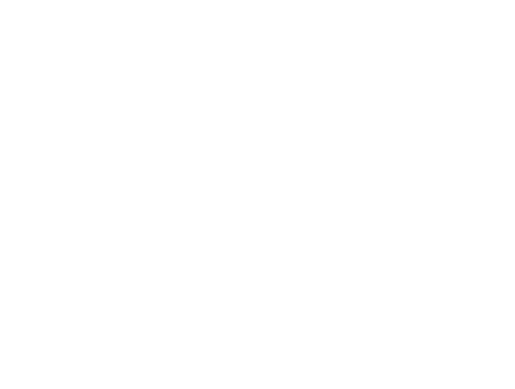

In [ ]:
# up
# for p_id in  [1409, 1927,1938,2067,1178,1944,699,1478,1620,2016,1520,
#              113,759,1913, 1764,1176,46,704,1869,2128,981]:
# down
# for p_id in [1537,1792,1924,1424,1182,1699,1705,1206,1335,2103,2104,317,453,1480,
#                 1871,2129,725,2132,365,1263,371,244,911,1679,1807]:
# mixed
# for p_id in [1041,1174,24,1179,1052,1436,1702,1842,1463,966,458,1227,
#                2122,345,2020,1001,1269, 2119,582]:


for p_id in [1041,1174,24,1179,1052,1436,1702,1842,1463,966,458,1227,
                2122,345,2020,1001,1269, 2119,582]:
    patient_visit = embedding_umap[patient_id == p_id]
    for pos in range(0, len(patient_visit)-1 ):
        x_pos = patient_visit[pos][0]
        y_pos = patient_visit[pos][1]
        x_direct = patient_visit[pos+1][0] - patient_visit[pos][0]
        y_direct = patient_visit[pos+1][1] - patient_visit[pos][1]
        ax.quiver(x_pos, y_pos, x_direct, y_direct, angles='xy', scale_units='xy', scale=1,
                   headwidth=2, linewidths = 1., alpha = 0.85,
                   color = sns.color_palette("Reds", 8)[pos])
plt.axis('off')
plt.show()